In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export
from exp.nb_06 import *

## ConvNet 

In [3]:
x_train, y_train, x_valid, y_valid = get_data()

x_train, x_valid = normalize_to(x_train, x_valid)
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

nh, bs = 50, 512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [4]:
mnist_view = view_tfm(1, 28, 28)
cbfs = [Recorder,
        partial(AvgStatsCallback, accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, mnist_view)]

In [5]:
nfs = [8, 16, 32, 64]

In [6]:
learn, run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [7]:
%time run.fit(2, learn)

train: [0.910771484375, tensor(0.7143)]
valid: [0.208728564453125, tensor(0.9366)]
train: [0.1861687109375, tensor(0.9439)]
valid: [0.21252236328125, tensor(0.9310)]
CPU times: user 24 s, sys: 1.64 s, total: 25.7 s
Wall time: 8.65 s


## Batchnorm 

In [8]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom, self.eps = mom, eps
        self.mults = nn.Parameter(torch.ones(nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer("vars", torch.ones(1,nf,1,1))
        self.register_buffer("means", torch.zeros(1,nf,1,1))
        
    def update_stats(self, x):
        m = x.mean((0,2,3), keepdim=True)
        v = x.var((0,2,3), keepdim=True)
        self.means.lerp_(m, self.mom)
        self.vars.lerp_(v, self.mom)
        return m,v
    
    def forward(self, x):
        if self.training:
            with torch.no_grad(): m, v = self.update_stats(x)
        else: m, v = self.means, self.vars
        x = (x-m) / (v+self.eps).sqrt()
        return x*self.mults + self.adds

In [9]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    # No bias needed if using bn
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(BatchNorm(nf))
    return nn.Sequential(*layers)

In [10]:
#export
def init_cnn_(m, f):
    if isinstance(m, nn.Conv2d):
        f(m.weight, a=0.1)
        if getattr(m, 'bias', None) is not None: m.bias.data.zero_()
    for l in m.children(): init_cnn_(l, f)
        
def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    init_cnn_(m, f)
    
def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [11]:
learn, run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs)

train: [0.48099484375, tensor(0.8630)]
valid: [0.2717147216796875, tensor(0.9153)]


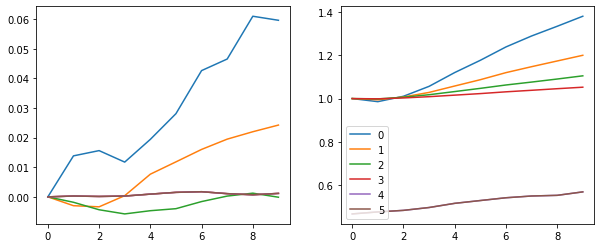

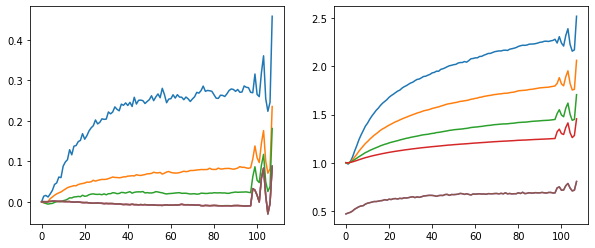

In [12]:
with Hooks(learn.model, append_stats) as hooks:
    run.fit(1, learn)
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,4))
    for h in hooks[:-1]:
        ms, ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)

In [13]:
learn, run = get_learn_run(nfs, data, 1.0, conv_layer, cbs=cbfs)

In [14]:
%time run.fit(3, learn)

train: [0.4188087890625, tensor(0.8824)]
valid: [0.204001123046875, tensor(0.9383)]
train: [0.180610390625, tensor(0.9451)]
valid: [0.18361697998046875, tensor(0.9446)]
train: [0.138150048828125, tensor(0.9583)]
valid: [0.1351724609375, tensor(0.9587)]
CPU times: user 58.3 s, sys: 3.4 s, total: 1min 1s
Wall time: 20.9 s


In [15]:
learn.model[0], learn.model[0].children()

(Sequential(
   (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
   (1): GeneralRelu()
   (2): BatchNorm()
 ), <generator object Module.children at 0x1a21287ad0>)

### Builtin batchnorm 

In [16]:
#export
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [17]:
learn, run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs)

In [18]:
%time run.fit(3, learn)

train: [0.2829629296875, tensor(0.9199)]
valid: [0.09155809936523437, tensor(0.9735)]
train: [0.071169033203125, tensor(0.9791)]
valid: [0.071509326171875, tensor(0.9776)]
train: [0.0511943896484375, tensor(0.9846)]
valid: [0.06521878662109375, tensor(0.9807)]
CPU times: user 1min 8s, sys: 3.45 s, total: 1min 12s
Wall time: 24.3 s


### With scheduler 

In [19]:
sched = combine_scheds([0.3, 0.7], [sched_lin(0.6, 2.), sched_lin(2., 0.1)])

In [20]:
learn, run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs +
                          [partial(ParamScheduler, 'lr', sched)])

In [21]:
run.fit(8, learn)

train: [0.367930390625, tensor(0.8968)]
valid: [0.12071939697265625, tensor(0.9639)]
train: [0.093219150390625, tensor(0.9719)]
valid: [0.10674359130859375, tensor(0.9684)]
train: [0.0609148779296875, tensor(0.9808)]
valid: [0.08485532836914063, tensor(0.9717)]
train: [0.0398159521484375, tensor(0.9881)]
valid: [0.0508111572265625, tensor(0.9842)]
train: [0.02806404541015625, tensor(0.9920)]
valid: [0.04748466796875, tensor(0.9860)]
train: [0.018831884765625, tensor(0.9954)]
valid: [0.04790602111816406, tensor(0.9855)]
train: [0.013782198486328124, tensor(0.9969)]
valid: [0.045276162719726565, tensor(0.9871)]
train: [0.01088361328125, tensor(0.9979)]
valid: [0.044250628662109374, tensor(0.9869)]


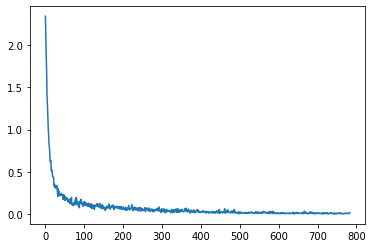

In [22]:
run.recorder.plot_loss()

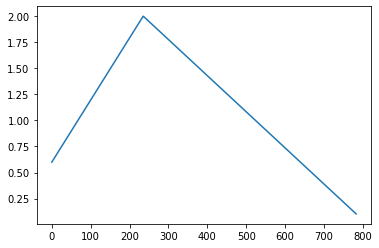

In [23]:
run.recorder.plot_lr()

In [24]:
its = x_train.shape[0]/512. * 8
its

781.25

In [25]:
0.3 * its, 0.7 * its # means for 3-% do linear increase, then remaining 70% do

(234.375, 546.875)

## More norms 

### Layer norm 

In [26]:
x_train[0].view(-1, 1, 28, 28).mean((1, 2, 3), keepdim=True).shape

torch.Size([1, 1, 1, 1])

In [27]:
class LayerNorm(nn.Module):
    __constants__ = ["eps"]
    def __init__(self, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add  = nn.Parameter(tensor(0.))
        
    def forward(self, x):
        # average on the channels instead on batches
        m = x.mean((1,2,3), keepdim=True)
        v = x.var ((1,2,3), keepdim=True)
        x = (x-m)/((v+self.eps).sqrt())
        return x*self.mult + self.add

In [28]:
def conv_ln(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(LayerNorm())
    return nn.Sequential(*layers)

In [29]:
learn, run = get_learn_run(nfs, data, 0.8, conv_ln, cbs=cbfs)

In [30]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): GeneralRelu()
    (2): LayerNorm()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralRelu()
    (2): LayerNorm()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralRelu()
    (2): LayerNorm()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GeneralRelu()
    (2): LayerNorm()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=64, out_features=10, bias=True)
)

In [31]:
%time run.fit(3, learn)

train: [0.45938671875, tensor(0.8541)]
valid: [0.12995316162109374, tensor(0.9621)]
train: [0.10361451171875, tensor(0.9674)]
valid: [0.08456785278320313, tensor(0.9750)]
train: [0.071346064453125, tensor(0.9777)]
valid: [0.08666611328125, tensor(0.9752)]
CPU times: user 1min 9s, sys: 5.63 s, total: 1min 15s
Wall time: 25.8 s


In [32]:
class InstanceNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, nf, eps=1e-0):
        super().__init__()
        self.eps = eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))

    def forward(self, x):
        # only mean filter, ignore batch and channel
        m = x.mean((2,3), keepdim=True)
        v = x.var ((2,3), keepdim=True)
        res = (x-m) / ((v+self.eps).sqrt())
        return res*self.mults + self.adds

In [33]:
def conv_in(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(InstanceNorm(nf))
    return nn.Sequential(*layers)

In [34]:
learn, run = get_learn_run(nfs, data, 0.1, conv_in, cbs=cbfs)

In [35]:
%time run.fit(3, learn)

train: [2.3021721875, tensor(0.1090)]
valid: [2.302011328125, tensor(0.1064)]
train: [2.301186875, tensor(0.1136)]
valid: [2.3019685546875, tensor(0.1064)]
train: [2.30111265625, tensor(0.1136)]
valid: [2.3019953125, tensor(0.1064)]
CPU times: user 1min 26s, sys: 5.81 s, total: 1min 32s
Wall time: 31.7 s


## 

In [ ]:
nb_auto_export()